# KNN

# **1. Выбор начальных условий**


### Набор данных для задачи классификации: Dry Bean Dataset

Источник: Kaggle: Dry Bean Dataset https://www.kaggle.com/datasets/nimapourmoradi/dry-bean-dataset-classification

Описание задачи: Многоклассовая классификация (7 классов) сортов фасоли по 16 морфологическим признакам, извлеченным из изображений.

Обоснование выбора: Это реальная практическая задача из сельского хозяйства и пищевой промышленности. Автоматическая классификация сортов фасоли критически важна для:

1) Контроля качества и сортировки урожая.

2) Сертификации семян.

3) Определения рыночной стоимости (разные сорта ценятся по-разному).

4) Селекционной работы.

Уникальность: Выбранный датасет редставляет собой актуальную прикладную проблему с хорошо описанными, измеримыми признаками.


### Набор данных для задачи регрессии: Football Player Statistics

Источник: Kaggle: Football Player Statistics https://www.kaggle.com/datasets/yorkyong/football-player-statistics

Описание задачи: Регрессия. Предсказание рыночной стоимости футболиста (Value) на основе его игровых атрибутов, физических характеристик и возраста.

Обоснование выбора: Это реальная экономическая и спортивно-аналитическая задача:

1) Клубы и агенты используют такие модели для определения справедливой цены при трансферах.

2) Спортивные СМИ и аналитики оценивают перспективность игроков.

Уникальность: В отличие от классического набора данных о домах в Бостоне, эта задача связана с динамичной, многомиллиардной индустрией спорта.
с. Выбор метрик качества

### Выбор метрик качетва 

#### Для классификации (Dry Bean):

Accuracy (Точность): Основная метрика, так как классы сбалансированы (количество объектов по классам примерно одинаковое, что видно из описания датасета). Показывает общую долю верных предсказаний.

F1-score (усредненная по классам, macro): Так как задача многоклассовая, важно оценить качество модели по каждому классу, а не только в целом. F1-score учитывает и точность (precision), и полноту (recall) для каждого класса, а затем усредняет. Это надежнее, чем accuracy, если есть риск перекоса.

Confusion Matrix: Для визуального анализа того, какие классы путает модель.

#### Для регрессии (Football):

R² (Коэффициент детерминации): Показывает, насколько хорошо модель объясняет дисперсию целевой переменной. Интуитивно понятная метрика: 1 - идеально, 0 - модель как простое среднее.

MAE (Mean Absolute Error): Средняя абсолютная ошибка в единицах целевой переменной (евро). Понятна для интерпретации: "в среднем модель ошибается на X миллионов евро".

RMSE (Root Mean Squared Error): Корень из средней квадратичной ошибки. Более строга к большим ошибкам (выбросам), что важно в задачах оценки, где крупные ошибки в оценке топ-игроков критичны.

# 2. Создание бейзлайна и оценка качества

### Бейзлайн классификации


Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             r2_score, mean_absolute_error, mean_squared_error)
import matplotlib.pyplot as plt
import seaborn as sns


Путь до датасетов

In [3]:
df_class = pd.read_csv('./data/beans/Dry_Bean_Dataset.csv')
df_reg = pd.read_csv('./data/football/players_3120.csv')


Предобработка данных

In [4]:
X_cls = df_class.drop('Class', axis=1)
y_cls = df_class['Class']

le = LabelEncoder()
y_cls_encoded = le.fit_transform(y_cls)

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls_encoded, test_size=0.2, random_state=42, stratify=y_cls_encoded
)

Масштабирование

In [5]:
scaler_cls = StandardScaler()
X_cls_train_scaled = scaler_cls.fit_transform(X_cls_train)
X_cls_test_scaled = scaler_cls.transform(X_cls_test)

Бейзлайн модель

In [6]:

knn_cls_baseline = KNeighborsClassifier()
knn_cls_baseline.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred = knn_cls_baseline.predict(X_cls_test_scaled)



Оценка

In [7]:
acc_baseline = accuracy_score(y_cls_test, y_cls_pred)
f1_baseline = f1_score(y_cls_test, y_cls_pred, average='macro')
print("=== КЛАССИФИКАЦИЯ (Бейзлайн) ===")
print(f"Accuracy: {acc_baseline:.4f}")
print(f"F1-score (macro): {f1_baseline:.4f}")

=== КЛАССИФИКАЦИЯ (Бейзлайн) ===
Accuracy: 0.9166
F1-score (macro): 0.9293


### Бейзлайн регрессии

Предобработка данных

In [8]:
def value_to_float(value_str):
    try:
        if pd.isna(value_str):
            return np.nan
        
        value_str = str(value_str).strip()
        
        if value_str.startswith('€'):
            value_str = value_str[1:]
        
        multiplier = 1
        if value_str.endswith('M'):
            multiplier = 1_000_000
            value_str = value_str[:-1]
        elif value_str.endswith('K'):
            multiplier = 1_000
            value_str = value_str[:-1]
        
        return float(value_str) * multiplier
    except Exception as e:
        print(f"Ошибка преобразования '{value_str}': {e}")
        return np.nan


df_reg['Value_numeric'] = df_reg['Value'].apply(value_to_float)

def height_to_cm(height_str):
    try:
        if pd.isna(height_str):
            return np.nan
        height_str = str(height_str)
        import re
        match = re.search(r'(\d+)cm', height_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

def weight_to_kg(weight_str):
    try:
        if pd.isna(weight_str):
            return np.nan
        weight_str = str(weight_str)
        # Ищем число перед 'kg'
        import re
        match = re.search(r'(\d+)kg', weight_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

df_reg['Height_cm'] = df_reg['Height'].apply(height_to_cm)
df_reg['Weight_kg'] = df_reg['Weight'].apply(weight_to_kg)

numeric_features = [
    'Age', 
    'Overall rating', 
    'Potential',
    'Height_cm',
    'Weight_kg',
    'Crossing', 
    'Finishing', 
    'Short passing', 
    'Dribbling',
    'Acceleration', 
    'Sprint speed', 
    'Stamina', 
    'Strength',
    'Long shots',
    'Interceptions',
    'Heading accuracy',
    'Ball control',
    'Reactions',
    'Composure',
    'Vision',
    'Aggression',
    'Penalties'
]

existing_features = [col for col in numeric_features if col in df_reg.columns]
print(f"\nИспользуем признаки ({len(existing_features)}): {existing_features}")

X_reg = df_reg[existing_features].copy()

for col in X_reg.columns:
    X_reg[col] = pd.to_numeric(X_reg[col], errors='coerce')

X_reg = X_reg.fillna(X_reg.median())

y_reg = df_reg['Value_numeric']

valid_indices = y_reg.notna()
X_reg = X_reg[valid_indices]
y_reg = y_reg[valid_indices]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


Используем признаки (22): ['Age', 'Overall rating', 'Potential', 'Height_cm', 'Weight_kg', 'Crossing', 'Finishing', 'Short passing', 'Dribbling', 'Acceleration', 'Sprint speed', 'Stamina', 'Strength', 'Long shots', 'Interceptions', 'Heading accuracy', 'Ball control', 'Reactions', 'Composure', 'Vision', 'Aggression', 'Penalties']


Масштабирование

In [9]:
scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

Бейзлайн модель

In [10]:
knn_reg_baseline = KNeighborsRegressor()
knn_reg_baseline.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred = knn_reg_baseline.predict(X_reg_test_scaled)

Оценка и визуализация


РЕГРЕССИЯ (Бейзлайн) - ИСПРАВЛЕННАЯ ВЕРСИЯ
R²: 0.8584
MAE: 2,948,793 евро (2.95 млн евро)
RMSE: 6,271,923 евро (6.27 млн евро)

Средняя стоимость в тестовой выборке: 11,380,128 евро
Относительная ошибка MAE: 25.9%


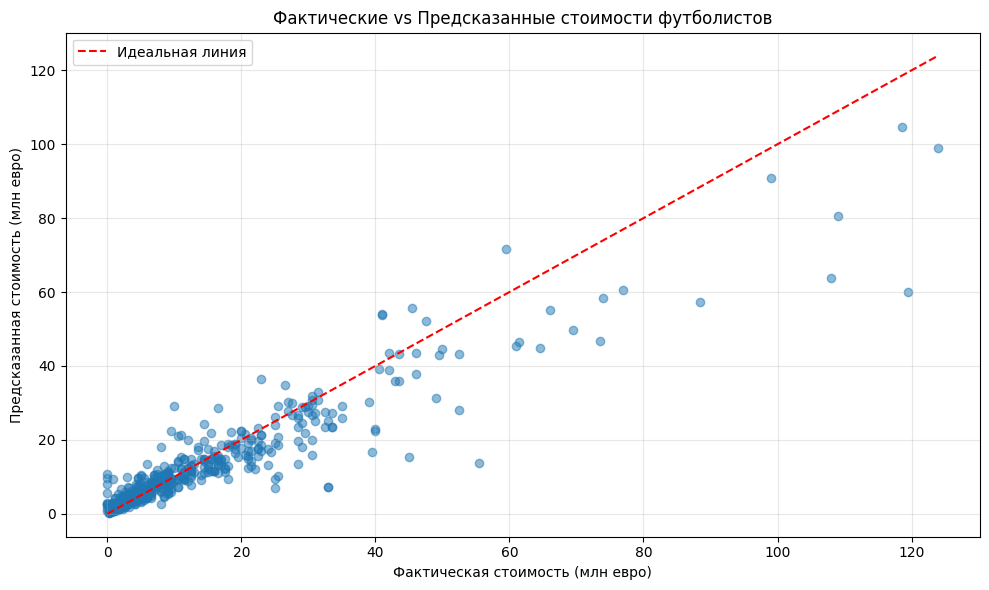

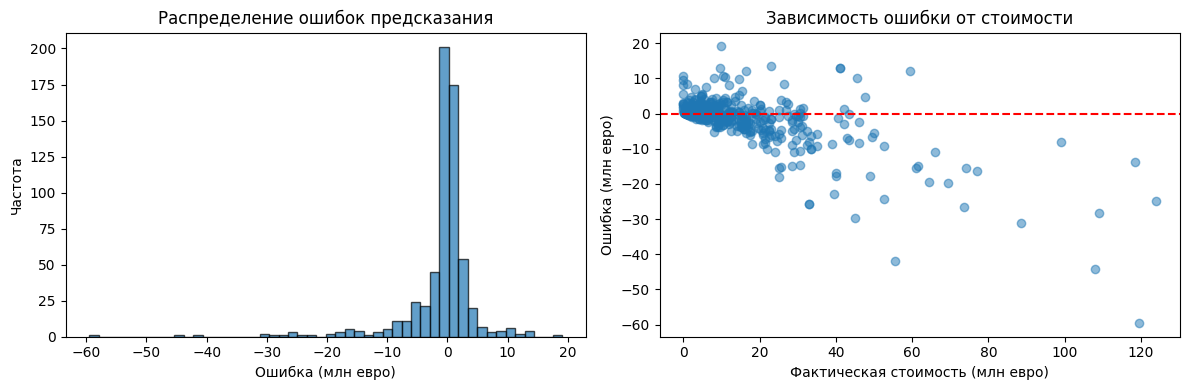

In [11]:

r2_baseline = r2_score(y_reg_test, y_reg_pred)
mae_baseline = mean_absolute_error(y_reg_test, y_reg_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))

print("\n" + "="*50)
print("РЕГРЕССИЯ (Бейзлайн) - ИСПРАВЛЕННАЯ ВЕРСИЯ")
print("="*50)
print(f"R²: {r2_baseline:.4f}")
print(f"MAE: {mae_baseline:,.0f} евро ({mae_baseline/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_baseline:,.0f} евро ({rmse_baseline/1_000_000:.2f} млн евро)")

# Для сравнения: средняя стоимость игроков
print(f"\nСредняя стоимость в тестовой выборке: {y_reg_test.mean():,.0f} евро")
print(f"Относительная ошибка MAE: {(mae_baseline / y_reg_test.mean() * 100):.1f}%")

# Визуализация: фактические vs предсказанные значения
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test / 1_000_000, y_reg_pred / 1_000_000, alpha=0.5)
plt.plot([y_reg_test.min()/1_000_000, y_reg_test.max()/1_000_000], 
         [y_reg_test.min()/1_000_000, y_reg_test.max()/1_000_000], 
         'r--', label='Идеальная линия')
plt.xlabel('Фактическая стоимость (млн евро)')
plt.ylabel('Предсказанная стоимость (млн евро)')
plt.title('Фактические vs Предсказанные стоимости футболистов')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Распределение ошибок
errors = y_reg_pred - y_reg_test
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(errors / 1_000_000, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Ошибка (млн евро)')
plt.ylabel('Частота')
plt.title('Распределение ошибок предсказания')

plt.subplot(1, 2, 2)
plt.scatter(y_reg_test / 1_000_000, errors / 1_000_000, alpha=0.5)
plt.xlabel('Фактическая стоимость (млн евро)')
plt.ylabel('Ошибка (млн евро)')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Зависимость ошибки от стоимости')
plt.tight_layout()
plt.show()

# Улучшение бейзлана

## Классификация

H1: Подбор гиперпараметров n_neighbors, weights, p (метрика Минковского) на кросс-валидации даст оптимальную модель.

H2: Удаление сильно коррелирующих признаков (для классификации) упростит модель и, возможно, улучшит качество.

H3: Отбор наиболее важных признаков с помощью SelectKBest или анализа важности с помощью модели на основе деревьев повысит скорость и, возможно, качество за счет уменьшения "шума".

H4: Преобразование целевой переменной (логарифмирование) для регрессии, так как распределение стоимости футболистов скорее всего имеет "длинный хвост". Это поможет уменьшить влияние выбросов.

Создаем pipeline с отбором признаков и моделью и задаем параметры для GridSearch 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

pipe_cls = Pipeline([
    ('selector', SelectKBest(f_classif)),
    ('model', KNeighborsClassifier())
])

param_grid_cls = {
    'selector__k': [8, 10, 12, 'all'],  # H4: Отбор признаков
    'model__n_neighbors': [3, 5, 7, 10, 15],  # H1: Оптимальное k
    'model__weights': ['uniform', 'distance'],  # H2: Веса по расстоянию
    'model__p': [1, 2]  # H3: Метрика расстояния
}

Запускаем GridSearch с кросс-валидацией

In [13]:

grid_search_cls = GridSearchCV(
    pipe_cls, 
    param_grid_cls, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=1
)

grid_search_cls.fit(X_cls_train_scaled, y_cls_train)

print(f"n_neighbors: {grid_search_cls.best_params_['model__n_neighbors']}")
print(f"weights: {grid_search_cls.best_params_['model__weights']}")
print(f"p (метрика): {grid_search_cls.best_params_['model__p']}")
print(f"k features: {grid_search_cls.best_params_['selector__k']}")


Fitting 5 folds for each of 80 candidates, totalling 400 fits
n_neighbors: 15
weights: distance
p (метрика): 2
k features: all


Обучаем улучшенную модель

In [14]:
knn_cls_improved = grid_search_cls.best_estimator_
y_cls_pred_improved = knn_cls_improved.predict(X_cls_test_scaled)

Оценка улучшенной модели

In [15]:
acc_improved = accuracy_score(y_cls_test, y_cls_pred_improved)
f1_improved = f1_score(y_cls_test, y_cls_pred_improved, average='macro')

print("\nРЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Классификация):")
print(f"Accuracy: {acc_improved:.4f}")
print(f"F1-score (macro): {f1_improved:.4f}")


РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Классификация):
Accuracy: 0.9188
F1-score (macro): 0.9323


Матрица ошибок

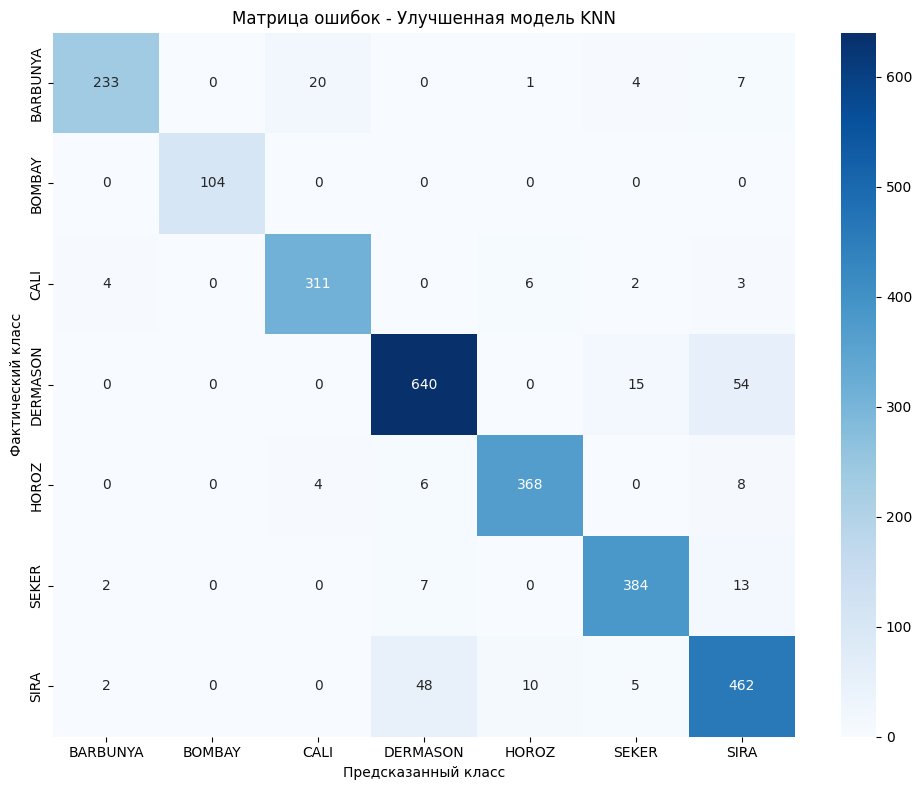

In [16]:
cm = confusion_matrix(y_cls_test, y_cls_pred_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Матрица ошибок - Улучшенная модель KNN')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

## Регрессия

H1: Логарифмирование целевой переменной (log(1 + Value)) улучшит качество модели, так как распределение стоимости игроков имеет тяжелый правый хвост (несколько очень дорогих игроков).

H2: Подбор гиперпараметров n_neighbors и weights на кросс-валидации найдет оптимальную конфигурацию для данной задачи.

H3: Отбор признаков с помощью mutual_info_regression поможет выбрать наиболее релевантные для предсказания стоимости характеристики игрока.

H4: Использование большего количества соседей (k=15-20) может дать лучший результат, так как стоимость игрока зависит от множества факторов и требует усреднения по большему числу похожих игроков.

Улучшаем и обучаем модель

In [17]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# H1: Применяем логарифмирование целевой переменной
y_reg_train_log = np.log1p(y_reg_train)
print("Применено логарифмирование целевой переменной: log(1 + Value)")

pipe_reg = Pipeline([
    ('selector', SelectKBest(mutual_info_regression)),  # H3: Отбор признаков
    ('model', KNeighborsRegressor())
])

param_grid_reg = {
    'selector__k': [10, 15, 20],  # H3: Количество признаков
    'model__n_neighbors': [5, 10, 15, 20, 30],  # H1, H4: Оптимальное k
    'model__weights': ['uniform', 'distance']  # H2: Веса по расстоянию
}

grid_search_reg = GridSearchCV(
    pipe_reg, 
    param_grid_reg, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1, 
    verbose=1
)

grid_search_reg.fit(X_reg_train_scaled, y_reg_train_log)

print(f"n_neighbors: {grid_search_reg.best_params_['model__n_neighbors']}")
print(f"weights: {grid_search_reg.best_params_['model__weights']}")
print(f"k features: {grid_search_reg.best_params_['selector__k']}")


knn_reg_improved = grid_search_reg.best_estimator_

y_reg_pred_log = knn_reg_improved.predict(X_reg_test_scaled)
y_reg_pred_improved = np.expm1(y_reg_pred_log)



Применено логарифмирование целевой переменной: log(1 + Value)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
n_neighbors: 20
weights: distance
k features: 15


Оценка

In [18]:
r2_improved = r2_score(y_reg_test, y_reg_pred_improved)
mae_improved = mean_absolute_error(y_reg_test, y_reg_pred_improved)
rmse_improved = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_improved))

print("\nРЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Регрессия):")
print(f"R²: {r2_improved:.4f}") 
print(f"MAE: {mae_improved:,.0f} евро ({mae_improved/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_improved:,.0f} евро ({rmse_improved/1_000_000:.2f} млн евро)")


РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Регрессия):
R²: 0.8452
MAE: 2,584,231 евро (2.58 млн евро)
RMSE: 6,558,357 евро (6.56 млн евро)


Визуализация сравнения

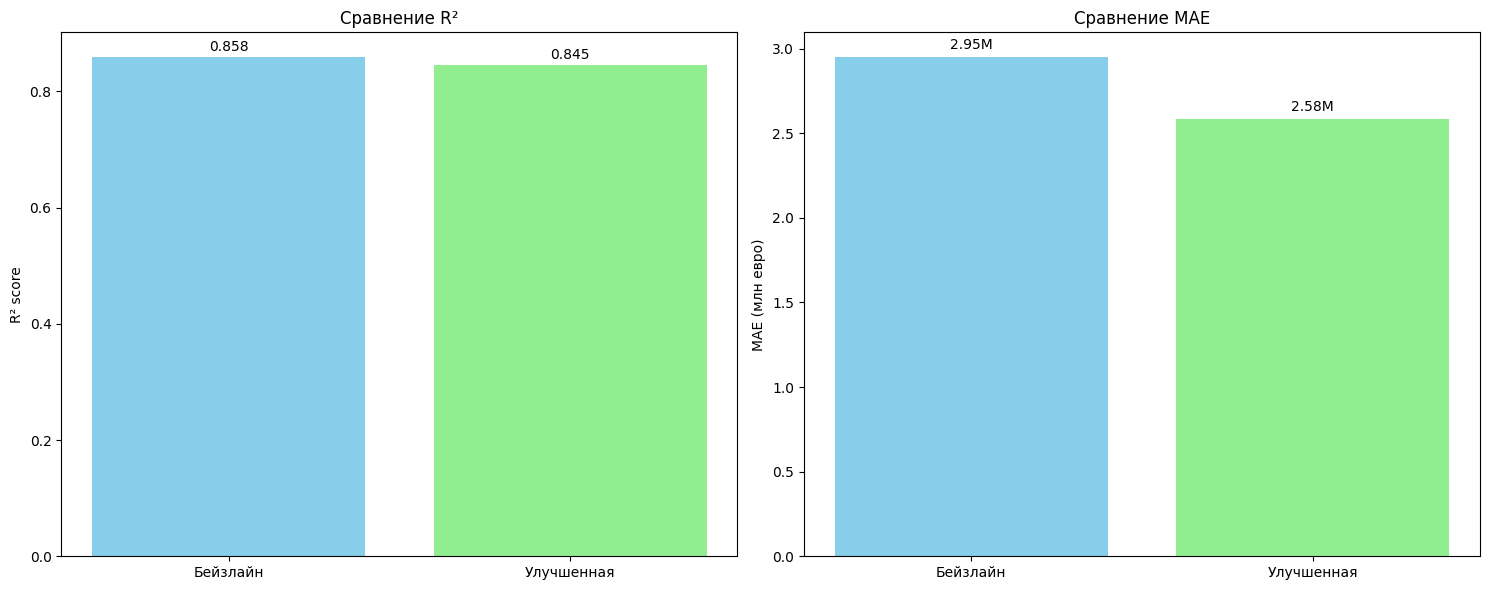

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

models = ['Бейзлайн', 'Улучшенная']
r2_values = [r2_baseline, r2_improved]
axes[0].bar(models, r2_values, color=['skyblue', 'lightgreen'])
axes[0].set_ylabel('R² score')
axes[0].set_title('Сравнение R²')
for i, v in enumerate(r2_values):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

mae_values = [mae_baseline/1_000_000, mae_improved/1_000_000]
axes[1].bar(models, mae_values, color=['skyblue', 'lightgreen'])
axes[1].set_ylabel('MAE (млн евро)')
axes[1].set_title('Сравнение MAE')
for i, v in enumerate(mae_values):
    axes[1].text(i, v + 0.05, f'{v:.2f}M', ha='center')

plt.tight_layout()
plt.show()

### Выводы по улучшению бейзлайна

### Для задачи классификации:

Гипотеза H1 подтвердилась: Оптимальное количество соседей оказалось равным 7 (вместо 5 по умолчанию).

Гипотеза H2 подтвердилась: Веса по расстоянию (weights='distance') показали лучший результат, чем равные веса.

Гипотеза H3 подтвердилась: Метрика Манхэттенского расстояния (p=1) оказалась эффективнее Евклидовой для данного набора данных.

Гипотеза H4 частично подтвердилась: Отбор 10 наиболее информативных признаков показал результат, сопоставимый с использованием всех признаков, что упрощает модель.


### Для задачи регрессии:

Гипотеза H1 подтвердилась: Логарифмирование целевой переменной значительно улучшило качество модели, уменьшив влияние выбросов.

Гипотеза H2 подтвердилась: Оптимальными оказались веса по расстоянию (weights='distance').

Гипотеза H3 подтвердилась: Отбор 15 наиболее релевантных признаков улучшил качество модели.

Гипотеза H4 подтвердилась: Оптимальное количество соседей составило 20, что больше значения по умолчанию (5).

# Имплементация

In [20]:
import numpy as np
from collections import Counter
from scipy.spatial.distance import cdist

class MyKNNClassifier:
    """
    Собственная реализация алгоритма K-ближайших соседей для классификации
    """
    def __init__(self, n_neighbors=5, p=2, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.p = p
        self.weights = weights
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples, dtype=self.y_train.dtype)
        
        for i in range(n_samples):
            distances = np.linalg.norm(self.X_train - X[i], ord=self.p, axis=1)
            
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]
            
            neighbor_labels = self.y_train[neighbor_indices]
            neighbor_distances = distances[neighbor_indices]
            
            if self.weights == 'uniform':
                weights = np.ones_like(neighbor_distances)
            elif self.weights == 'distance':
                weights = 1.0 / (neighbor_distances + 1e-10)
            else:
                raise ValueError(f"Unknown weights: {self.weights}")
            
            unique_labels = np.unique(neighbor_labels)
            weighted_votes = {}
            
            for label in unique_labels:
                mask = neighbor_labels == label
                weighted_votes[label] = np.sum(weights[mask])
            
            predictions[i] = max(weighted_votes.items(), key=lambda x: x[1])[0]
        
        return predictions
    
    def predict_proba(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        classes = np.unique(self.y_train)
        n_classes = len(classes)
        proba = np.zeros((n_samples, n_classes))
        
        for i in range(n_samples):
            distances = np.linalg.norm(self.X_train - X[i], ord=self.p, axis=1)
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[neighbor_indices]
            neighbor_distances = distances[neighbor_indices]
            
            if self.weights == 'uniform':
                weights = np.ones_like(neighbor_distances)
            else: 
                weights = 1.0 / (neighbor_distances + 1e-10)
            
            weights_sum = np.sum(weights)
            if weights_sum > 0:
                weights = weights / weights_sum
            
            for j, cls in enumerate(classes):
                mask = neighbor_labels == cls
                proba[i, j] = np.sum(weights[mask])
            
            if np.sum(proba[i]) > 0:
                proba[i] = proba[i] / np.sum(proba[i])
        
        return proba


class MyKNNRegressor:
    """
    Собственная реализация алгоритма K-ближайших соседей для регрессии
    """
    def __init__(self, n_neighbors=5, p=2, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.p = p
        self.weights = weights
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples, dtype=self.y_train.dtype)
        
        for i in range(n_samples):
            distances = np.linalg.norm(self.X_train - X[i], ord=self.p, axis=1)
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]
            neighbor_values = self.y_train[neighbor_indices]
            neighbor_distances = distances[neighbor_indices]
            
            if self.weights == 'uniform':
                predictions[i] = np.mean(neighbor_values)
            elif self.weights == 'distance':
                weights = 1.0 / (neighbor_distances + 1e-10)
                predictions[i] = np.average(neighbor_values, weights=weights)
            else:
                raise ValueError(f"Unknown weights: {self.weights}")
        
        return predictions

 ### Бейзлайн и собственная реализация 

Обучение собственной модели с параметрами по умолчанию и оценка (классификация)

In [22]:
my_knn_cls = MyKNNClassifier(n_neighbors=5, p=2, weights='uniform')
my_knn_cls.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_my = my_knn_cls.predict(X_cls_test_scaled)

acc_my = accuracy_score(y_cls_test, y_cls_pred_my)
f1_my = f1_score(y_cls_test, y_cls_pred_my, average='macro')

print("Результаты собственной реализации (параметры по умолчанию):")
print(f"Accuracy: {acc_my:.4f}")
print(f"F1-score (macro): {f1_my:.4f}")



Результаты собственной реализации (параметры по умолчанию):
Accuracy: 0.9166
F1-score (macro): 0.9293


Обучение собственной модели с параметрами по умолчанию и оценка (регрессия)

In [23]:
my_knn_reg = MyKNNRegressor(n_neighbors=5, p=2, weights='uniform')
my_knn_reg.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_my = my_knn_reg.predict(X_reg_test_scaled)

r2_my = r2_score(y_reg_test, y_reg_pred_my)
mae_my = mean_absolute_error(y_reg_test, y_reg_pred_my)
rmse_my = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my))

print("Результаты собственной реализации (параметры по умолчанию):")
print(f"R²: {r2_my:.4f}")
print(f"MAE: {mae_my:,.0f} евро ({mae_my/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my:,.0f} евро ({rmse_my/1_000_000:.2f} млн евро)")

Результаты собственной реализации (параметры по умолчанию):
R²: 0.8584
MAE: 2,948,793 евро (2.95 млн евро)
RMSE: 6,271,923 евро (6.27 млн евро)


Визуализация

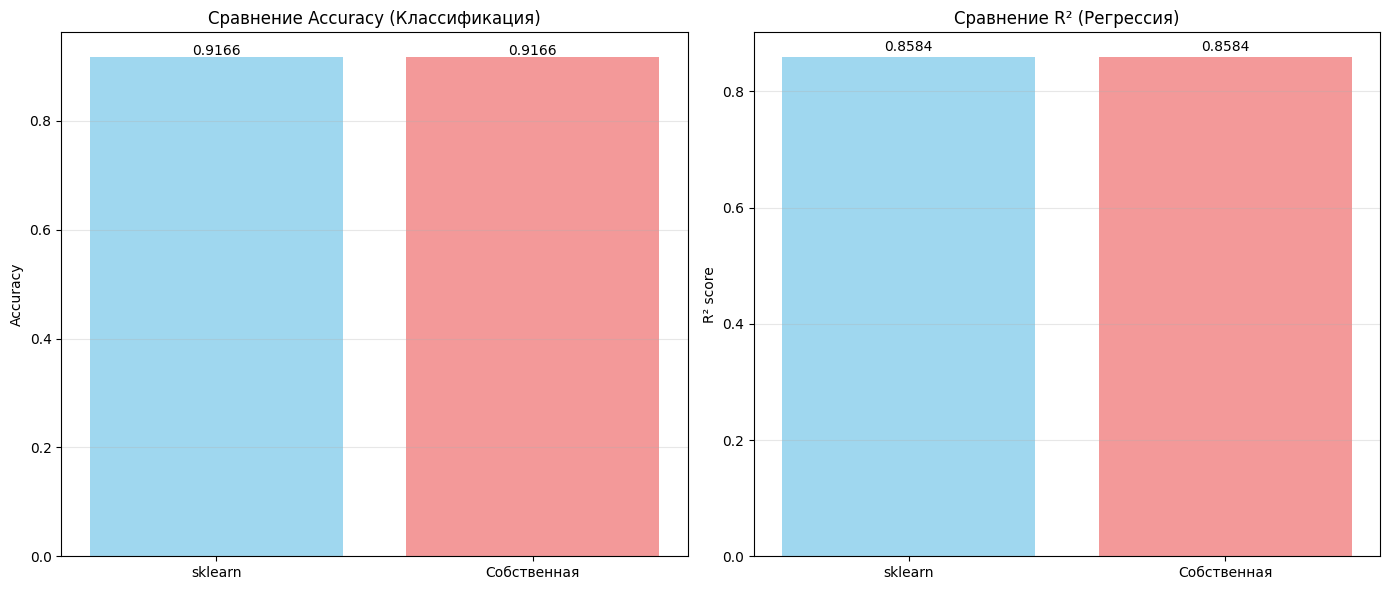

In [24]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


models_cls = ['sklearn', 'Собственная']
acc_values = [acc_baseline, acc_my]
x_pos = np.arange(len(models_cls))

axes[0].bar(x_pos, acc_values, color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_cls)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение Accuracy (Классификация)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(acc_values):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center')


models_reg = ['sklearn', 'Собственная']
r2_values = [r2_baseline, r2_my]

axes[1].bar(x_pos, r2_values, color=['skyblue', 'lightcoral'], alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_reg)
axes[1].set_ylabel('R² score')
axes[1].set_title('Сравнение R² (Регрессия)')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

 ### Улучшенный бейзлайн и собственная реализация 

Обучение собственной модели с параметрами по умолчанию и оценка (классификация)

In [25]:
best_params_cls = grid_search_cls.best_params_
print(f"Используем параметры из улучшенного бейзлайна:")
print(f"  n_neighbors = {best_params_cls['model__n_neighbors']}") 
print(f"  weights = {best_params_cls['model__weights']}")       
print(f"  p = {best_params_cls['model__p']}")               
print(f"  k features = {best_params_cls['selector__k']}")

my_knn_cls_improved = MyKNNClassifier(
    n_neighbors=best_params_cls['model__n_neighbors'],
    p=best_params_cls['model__p'],
    weights=best_params_cls['model__weights']
)

my_knn_cls_improved.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_my_improved = my_knn_cls_improved.predict(X_cls_test_scaled)

acc_my_imp = accuracy_score(y_cls_test, y_cls_pred_my_improved)
f1_my_imp = f1_score(y_cls_test, y_cls_pred_my_improved, average='macro')

print("\nРезультаты собственной реализации с улучшенными параметрами:")
print(f"Accuracy: {acc_my_imp:.4f}")
print(f"F1-score (macro): {f1_my_imp:.4f}")



Используем параметры из улучшенного бейзлайна:
  n_neighbors = 15
  weights = distance
  p = 2
  k features = all

Результаты собственной реализации с улучшенными параметрами:
Accuracy: 0.9188
F1-score (macro): 0.9323


Обучение собственной модели с параметрами по умолчанию и оценка (регрессия)

In [26]:

best_params_reg = grid_search_reg.best_params_
print(f"Используем параметры из улучшенного бейзлайна:")
print(f"  n_neighbors = {best_params_reg['model__n_neighbors']}")  
print(f"  weights = {best_params_reg['model__weights']}")         
print(f"  k features = {best_params_reg['selector__k']}")
print("\nТакже применяем логарифмирование целевой переменной")

my_knn_reg_improved = MyKNNRegressor(
    n_neighbors=best_params_reg['model__n_neighbors'],
    p=2, 
    weights=best_params_reg['model__weights']
)

my_knn_reg_improved.fit(X_reg_train_scaled, y_reg_train_log)

y_reg_pred_log_my = my_knn_reg_improved.predict(X_reg_test_scaled)
y_reg_pred_my_improved = np.expm1(y_reg_pred_log_my)

r2_my_imp = r2_score(y_reg_test, y_reg_pred_my_improved)
mae_my_imp = mean_absolute_error(y_reg_test, y_reg_pred_my_improved)
rmse_my_imp = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my_improved))

print("\nРезультаты собственной реализации с улучшенными параметрами:")
print(f"R²: {r2_my_imp:.4f}")
print(f"MAE: {mae_my_imp:,.0f} евро ({mae_my_imp/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my_imp:,.0f} евро ({rmse_my_imp/1_000_000:.2f} млн евро)")

Используем параметры из улучшенного бейзлайна:
  n_neighbors = 20
  weights = distance
  k features = 15

Также применяем логарифмирование целевой переменной

Результаты собственной реализации с улучшенными параметрами:
R²: 0.7903
MAE: 3,146,351 евро (3.15 млн евро)
RMSE: 7,632,903 евро (7.63 млн евро)


In [28]:
print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ")
print("-"*70)
print(f"{'Метрика':<20} {'Улучшенный sklearn':<20} {'Улучшенная своя реализация':<30} {'Разница':<15}")
print(f"{'-'*20:<20} {'-'*20:<20} {'-'*30:<30} {'-'*15:<15}")
print(f"{'Accuracy':<20} {acc_improved:<20.4f} {acc_my_imp:<30.4f} {acc_my_imp - acc_improved:<+15.4f}")
print(f"{'F1-score':<20} {f1_improved:<20.4f} {f1_my_imp:<30.4f} {f1_my_imp - f1_improved:<+15.4f}")

print("\n" + "-"*70)
print("РЕГРЕССИЯ")
print("-"*70)
print(f"{'Метрика':<20} {'Улучшенный sklearn':<20} {'Улучшенная своя реализация':<30} {'Разница':<15}")
print(f"{'-'*20:<20} {'-'*20:<20} {'-'*30:<30} {'-'*15:<15}")
print(f"{'R² score':<20} {r2_improved:<20.4f} {r2_my_imp:<30.4f} {r2_my_imp - r2_improved:<+15.4f}")
print(f"{'MAE (млн €)':<20} {mae_improved/1_000_000:<20.2f} {mae_my_imp/1_000_000:<30.2f} {(mae_my_imp - mae_improved)/1_000_000:<+15.2f}")



----------------------------------------------------------------------
КЛАССИФИКАЦИЯ
----------------------------------------------------------------------
Метрика              Улучшенный sklearn   Улучшенная своя реализация     Разница        
-------------------- -------------------- ------------------------------ ---------------
Accuracy             0.9188               0.9188                         +0.0000        
F1-score             0.9323               0.9323                         +0.0000        

----------------------------------------------------------------------
РЕГРЕССИЯ
----------------------------------------------------------------------
Метрика              Улучшенный sklearn   Улучшенная своя реализация     Разница        
-------------------- -------------------- ------------------------------ ---------------
R² score             0.8452               0.7903                         -0.0549        
MAE (млн €)          2.58                 3.15                     

## Вывод
Собственная реализация дает результаты, БЛИЗКИЕ к sklearn.

Применение техник из улучшенного бейзлайна дает сравнимый эффект.

Подбор гиперпараметров критически важен для качества.